In [102]:
from PIL import Image
import numpy as np
from pathlib import Path
import tifffile as tiff

In [103]:
single_dir = Path('100ms56864720mwproteins_1/single/')
frame_0 = single_dir / '100ms56864720mw_1_MMStack_Pos0.ome'

In [104]:
im = Image.open(single_dir / '100ms56864720mw_1_MMStack_Pos0.ome.tif')

In [105]:
image_array = np.array(im)

In [106]:
image_array.shape

(1024, 1024)

In [107]:
def open_and_print_shape(im_path):
    im = Image.open(im_path)
    image_array = np.array(im)
    print(image_array.shape)

open_and_print_shape('100ms56864720mwproteins_1/100ms56864720mw_1_MMStack_Pos0.ome.tif')

(1024, 1024)


In [108]:
open_and_print_shape('100ms56864720mwproteins_1/100ms56864720mw_1_MMStack_Pos0_1.ome.tif')

(1024, 1024)


In [109]:
open_and_print_shape('100ms56864720mwproteins_1/100ms56864720mw_1_MMStack_Pos0_2.ome.tif')

(1024, 1024)


In [110]:
# Read in the region of interest file and get the coordinates
background_pos = frame_0 / 'Expanded_Channel_1_Background_Positions.csv'
roi_pos = frame_0 / 'Expanded_Channel_1_ROI_Positions.csv'
with open(background_pos, 'r') as f:
    bg_pos = f.readlines()
    bg_1 = [int(r) for r in bg_pos[2].split(',')]
with open(roi_pos, 'r') as f:
    r_pos = f.readlines()
    roi_1 = [int(r) for r in r_pos[2].split(',')]
        

In [111]:
bg_coords = np.unravel_index(bg_1, (1024, 1024))
roi_coords = np.unravel_index(roi_1, (1024, 1024))

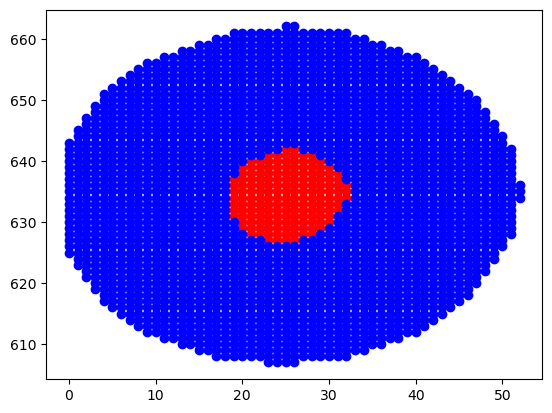

In [112]:
# plot the coordinates
import matplotlib.pyplot as plt
plt.scatter(roi_coords[0], roi_coords[1], color='red')
plt.scatter(bg_coords[0], bg_coords[1], color='blue')

In [113]:
Path(single_dir / 'subtiffs').mkdir(exist_ok=True)

Reads in the coordinates and extracts a square subtiff for each ROI + background, 
saves these in a subtiffs directory.
Requires the tiff already, i.e., doesn't work on a frame by frame basis but that is easy to switch to

In [114]:
# Read in a tiff file
# For every frame in the tiff, and for every set of ROI and background pixels
# extract all the pixels in the ROI and background
# and save them to a new tiff file
# so that we have a tiff file with the same number of frames as the original for each ROI and background

# Get all the ROI and background pixel coordinates
background_pos = frame_0 / 'Expanded_Channel_1_Background_Positions.csv'
roi_pos = frame_0 / 'Expanded_Channel_1_ROI_Positions.csv'
with open(background_pos, 'r') as f:
    bg_pos = f.readlines()[2:]
    # convert the list of lists to a list of lists of ints
    bg_pos = [[int(val) for val in region.strip().split(',')] for region in bg_pos]
with open(roi_pos, 'r') as f:
    r_pos = f.readlines()[2:]
    # convert the list of lists to a list of lists of ints
    r_pos = [[int(val) for val in region.strip().split(',')] for region in r_pos]
 
## TODO: extract coordinates for second channel and extract the subtiffs for the second channel
# Read in the tiff file
t = tiff.imread(single_dir / '100ms56864720mw_1_MMStack_Pos0.ome.tif')
# For each ROI and background
arr = np.array(t)
for j in range(len(r_pos)):
    # Extract the pixels in the ROI and background
    roi_y, roi_x = np.unravel_index(r_pos[j], (1024, 1024))
    bg_y, bg_x = np.unravel_index(bg_pos[j], (1024, 1024))
    # get the max and min values of the ROI and background pixels
    min_y, max_y = min(bg_y), max(bg_y)
    min_x, max_x = min(bg_x), max(bg_x)
    # t has shape (frames, channels, y, x)
    # we want to extract all the frames, all the channels, and the pixels determined by min_x, max_x, min_y, max_y
    subtiff = arr[:, :, min_y:max_y, min_x:max_x]
    # create a new coordinate system for the ROI and background pixels in the subtiff
    new_roi_y = roi_y - min_y
    new_roi_x = roi_x - min_x
    new_bg_y = bg_y - min_y
    new_bg_x = bg_x - min_x
    # write the new coordinates to a file where the first column is the ROI y coordinate, the second column is the ROI x coordinate, the third column is the background y coordinate, and the fourth column is the background x coordinate
    # and there is a column for each ROI number

    # save the subtiff to a new tiff file
    tiff.imwrite(single_dir / 'subtiffs' / f'100ms56864720mw_1_MMStack_Pos0_roi{j}.ome.tif', subtiff)

<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1006, 1, 1, 2) of (50000, 1, 1, 2)
<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack is missing 1 pages. Missing data are zeroed


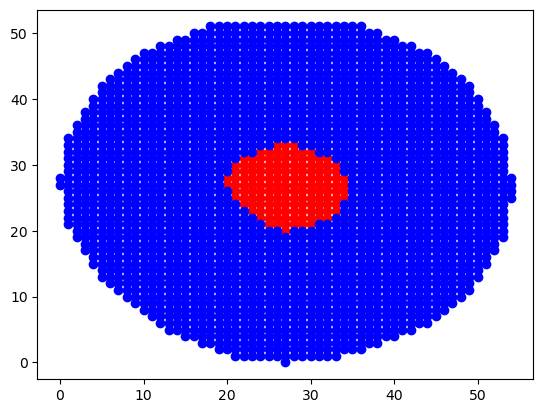

In [115]:
# plot example showing the transformed coordinates
plt.scatter(new_roi_x, new_roi_y, color='red')
plt.scatter(new_bg_x, new_bg_y, color='blue')
plt.show()

Frame by frame approach, going through all ROIs on each frame

In [116]:
# First extract the coordinates for both channels
def extract_coordinates(background_pos_file : str, roi_pos_file :str):
    """ 
    Extract the coordinates from the background and ROI position files

    Parameters
    ----------
    background_pos_file : str
        The path to the background position file
    roi_pos_file : str
        The path to the ROI position file

    Returns
    -------
    bg_pos : list
        A list of lists of ints representing the background coordinates
    r_pos : list
        A list of lists of ints representing the ROI coordinates
    """
    with open(background_pos_file, 'r') as f:
        bg_pos = f.readlines()[2:]
        # convert the list of lists to a list of lists of ints
        bg_pos = [[int(val) for val in region.strip().split(',')] for region in bg_pos]
    with open(roi_pos_file, 'r') as f:
        r_pos = f.readlines()[2:]
        # convert the list of lists to a list of lists of ints
        r_pos = [[int(val) for val in region.strip().split(',')] for region in r_pos]
    return bg_pos, r_pos

# Get all the ROI and background pixel coordinates for both channels
background_pos_ch1 = frame_0 / 'Expanded_Channel_1_Background_Positions.csv'
roi_pos_ch1 = frame_0 / 'Expanded_Channel_1_ROI_Positions.csv'
background_pos_ch2 = frame_0 / 'Expanded_Channel_2_Background_Positions.csv'
roi_pos_ch2 = frame_0 / 'Expanded_Channel_2_ROI_Positions.csv'

bg_ch1_coords, roi_ch1_coords = extract_coordinates(background_pos_ch1, roi_pos_ch1)
bg_ch2_coords, roi_ch2_coords = extract_coordinates(background_pos_ch2, roi_pos_ch2)

In [117]:
# Assume we have been given a frame
t = tiff.imread(single_dir / '100ms56864720mw_1_MMStack_Pos0.ome.tif')
t.shape

<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1006, 1, 1, 2) of (50000, 1, 1, 2)
<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack is missing 1 pages. Missing data are zeroed


(1006, 2, 1024, 1024)

In [118]:
def extract_square_pixels(bg_coords: np.array) -> tuple:
    """ 
    Extract the pixels from the given coordinates

    Parameters
    ----------
    bg_coords : np.array
        An array of background coordinates

    Returns
    -------
    min_x : int
        The minimum x coordinate of the background
    max_x : int
        The maximum x coordinate of the background
    min_y : int
        The minimum y coordinate of the background
    max_y : int
        The maximum y coordinate of the background
    
    """

    # Extract the pixels in the ROI
    bg_y, bg_x = np.unravel_index(bg_coords, (1024, 1024))
    # Get the smallest square that contains all the pixels
    min_y, max_y = min(bg_y), max(bg_y)
    min_x, max_x = min(bg_x), max(bg_x)
    # adjust the above values if they are not square
    if max_y - min_y != max_x - min_x:
        # if the y values are larger than the x values
        if max_y - min_y > max_x - min_x:
            # increase the x values
            max_x = min_x + (max_y - min_y)
        else:
            # increase the y values
            max_y = min_y + (max_x - min_x)
    return (min_y, max_y, min_x, max_x)

Something like the below can be done if frame by frame extraction is desired:
* Given a frame, assume we know its channel
* Extract every ROI from this frame in a loop
* then process the next frame (which will be from a different channel)
* coordinate system can be corrected after

In [119]:
# Have a flag to extract coords for channel 1 or channel 2
channel = 1 # can be determined from metadata
bg_coords = bg_ch1_coords if channel==1 else bg_ch2_coords

ratios = {i: [] for i in range(len(bg_coords))}
for frame in range(t.shape[0]):
    for i in range(len(bg_coords)):
        # Extract the pixels for the square subtiff from the given coordinates
        (min_y, max_y, min_x, max_x) = extract_square_pixels(bg_coords[i])
        subtiff = np.array(t[frame, channel, :, :])[min_y:max_y, min_x:max_x]
        # Find x and y coordinates of the maximum value in subtiff
        maxi_y, maxi_x = np.unravel_index(subtiff.argmax(), subtiff.shape)
        # Extract a 10x10 square around the maximum value
        min_y, max_y, min_x,max_x = maxi_y - 5, maxi_y + 5, maxi_x - 5, maxi_x + 5
        # Extract the pixels for the square subtiff from the given coordinates
        maxi_bg = subtiff[min_y:max_y, min_x:max_x]
        if maxi_bg.shape != (10, 10):
            ratios[i].append(0)
            continue
        # Get the average value of pixels in the 5x5 square excluding the maximum value
        avg = np.mean(maxi_bg[maxi_bg != maxi_bg.max()])
        # Get the ratio of the maximum value to the average value
        ratio = maxi_bg.max() / avg
        # Add the ratio to the list of ratios for the given background
        ratios[i].append(ratio)


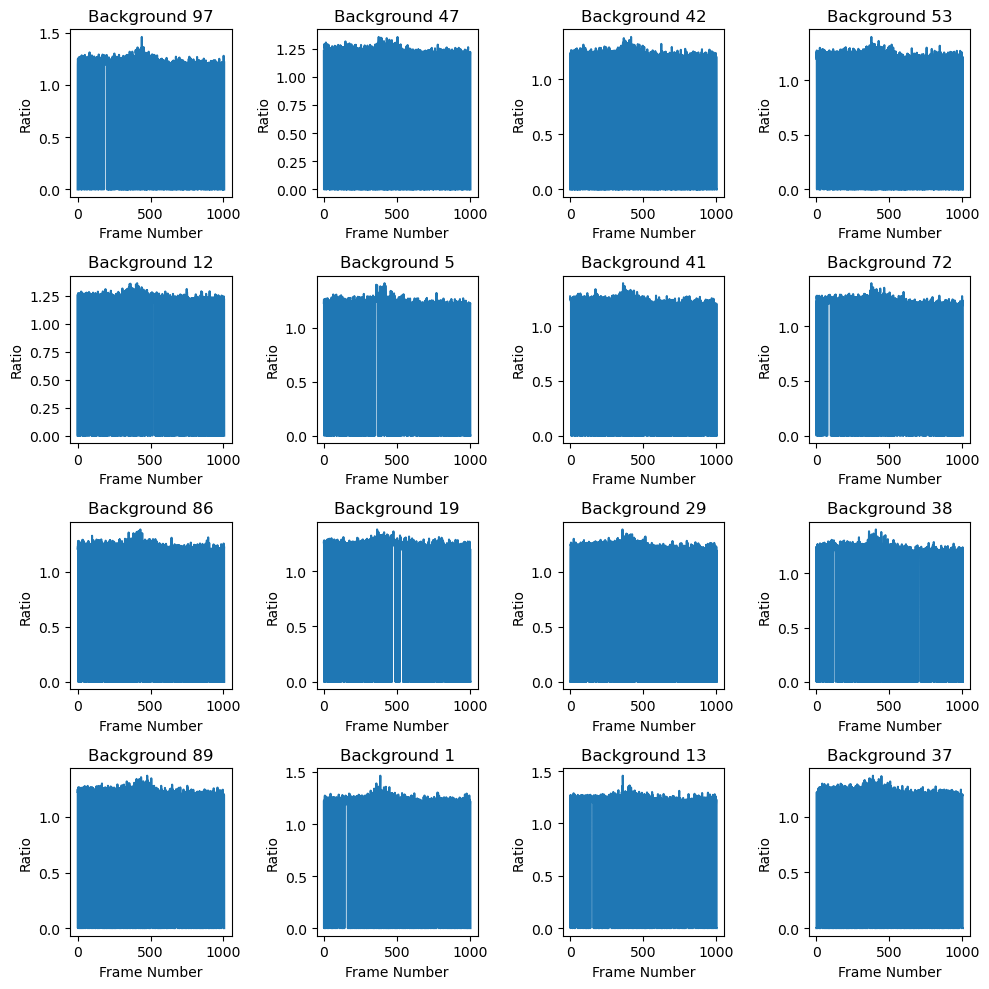

In [120]:
# Plot the ratios for each background across all frames
# plot 16 of the ratio lists in a 4x4 grid
# select 16 random ratio lists
import random
random_indices = random.sample(range(len(ratios)), 16)
# plot the ratios for each background across all frames
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
idx = 0
for i in range(4):
    for j in range(4):
        axs[i, j].plot(ratios[random_indices[i*4 + j]])
        axs[i, j].set_title(f'Background {random_indices[i*4 + j]}')
        # Label y axis as ratio and x axis as frame number
        axs[i, j].set_ylabel('Ratio')
        axs[i, j].set_xlabel('Frame Number')
        # make sure there is no overlap between the subplots
        plt.tight_layout()
        idx += 1
plt.show()

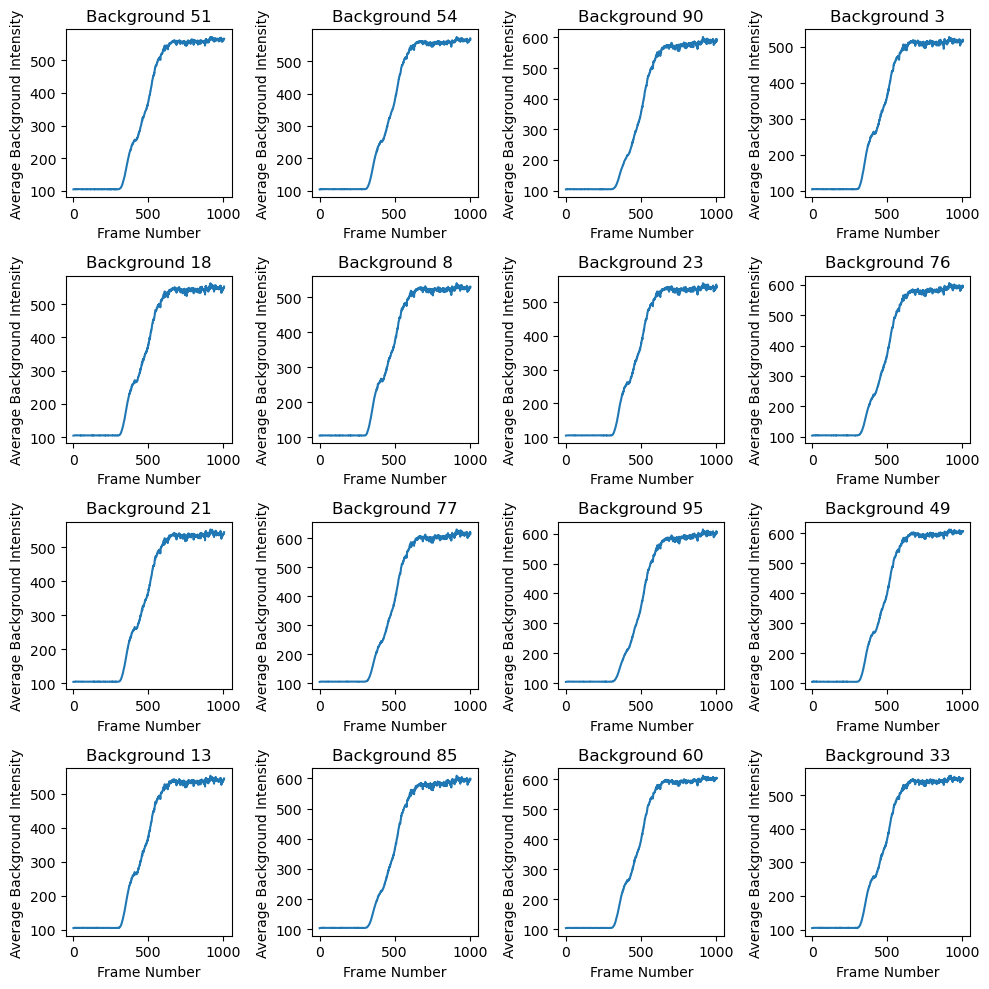

In [121]:
# Plotting just the background intensities, expecting a jump as dye is flowed in after 500 frames.
# Have a flag to extract coords for channel 1 or channel 2
channel = 1 # can be determined from metadata
bg_coords = bg_ch1_coords if channel==1 else bg_ch2_coords

avg_bg = {i: [] for i in range(len(bg_coords))}
for frame in range(t.shape[0]):
    for i in range(len(bg_coords)):
        # Get x and y coordinates of the background pixels
        bg_y, bg_x = np.unravel_index(bg_coords[i], (1024, 1024))
        # Extract just the background pixels using the x and y coordinates
        bg = np.array(t[frame, channel, :, :])[bg_y, bg_x]
        # Add the average value of the background pixels to the list of average background values
        avg_bg[i].append(np.mean(bg))

# Plot the average background intensity for each background across all frames
# plot 16 of the average background intensities in a 4x4 grid
# Choose 16 random indices
random_indices = random.sample(range(len(avg_bg)), 16)
# plot the average background intensity for each background across all frames
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
idx = 0
for i in range(4):
    for j in range(4):
        axs[i, j].plot(avg_bg[random_indices[i*4 + j]][:-1])
        axs[i, j].set_title(f'Background {random_indices[i*4 + j]}')
        # Label y axis as ratio and x axis as frame number
        axs[i, j].set_ylabel('Average Background Intensity')
        axs[i, j].set_xlabel('Frame Number')
        # make sure there is no overlap between the subplots
        plt.tight_layout()
        idx += 1

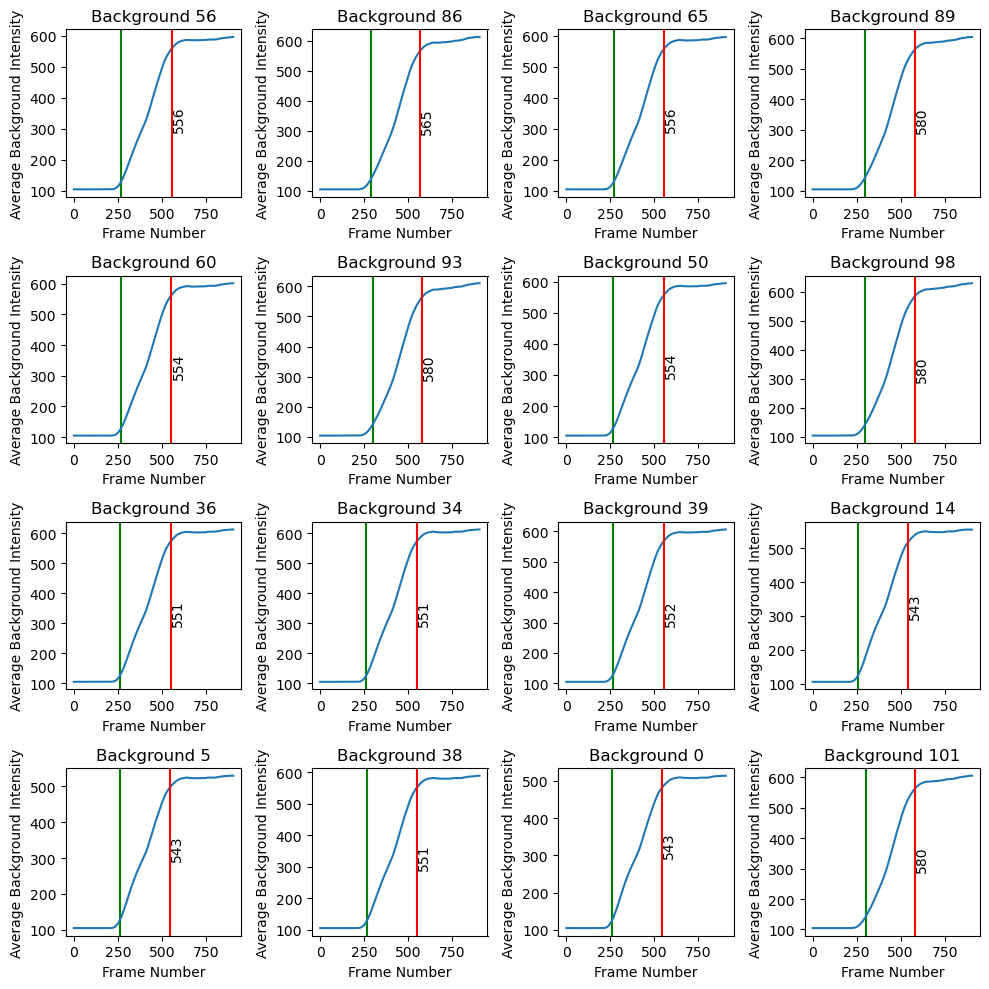

In [122]:
# Using the kneed package to pick the elbow from the moving average of background intensity and plotting it on the above graphs
from kneed import KneeLocator

# Plot the average background intensity for each background across all frames
# plot 16 of the average background intensities in a 4x4 grid
# Choose 16 random indices
ma = 100
start_threshold = 1
random_indices = random.sample(range(len(avg_bg)), 16)
# plot the average background intensity for each background across all frames
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
idx = 0
for i in range(4):
    for j in range(4):
        # plot the moving average across 50 frames
        y = np.convolve(avg_bg[random_indices[i*4 + j]][:-1], np.ones(ma), 'valid') / ma
        # find the first frame where the change in background intensity is greater than a threshold
        for k in range(len(y)-1):
            if y[k+1] - y[k] > start_threshold:
                start = k
                break
        # plot this value as a vertical line
        axs[i, j].axvline(start, color='green')
        axs[i, j].plot(y)
        # Get the knee of this moving average data
        x = np.arange(len(y))
        kneedle = KneeLocator(x[start:], y[start:], curve='concave', direction='increasing')
        # Plot the knee
        axs[i, j].axvline(kneedle.knee, color='red')
        # label the frame number of the knee
        axs[i, j].text(kneedle.knee, 300, f'{kneedle.knee}', rotation=90)
        axs[i, j].set_title(f'Background {random_indices[i*4 + j]}')
        # Label y axis as ratio and x axis as frame number
        axs[i, j].set_ylabel('Average Background Intensity')
        axs[i, j].set_xlabel('Frame Number')
        # make sure there is no overlap between the subplots
        plt.tight_layout()
        idx += 1




In [123]:
# Create a function to calculate the average intensity across a set of pixels within a tiff stack
def calculate_average_intensity(tiff_stack: np.array, indices: np.array) -> list:
    """ 
    Calculate the average intensity across a set of pixels within a tiff stack,
    assuming the stack is single channel

    Parameters
    ----------
    tiff_stack : np.array
        A numpy array representing a tiff stack
    indices : np.array
        A numpy array representing the indices of the pixels to calculate the average intensity for

    Returns
    -------
    avg : list
        A list of average intensities for each frame in the tiff stack
    """

    avg_bg = {i: [] for i in range(len(indices))}
    for frame in range(tiff_stack.shape[0]):
        for i in range(len(indices)):
            # Get x and y coordinates of the background pixels
            bg_y, bg_x = np.unravel_index(indices[i], (1024, 1024))
            # Extract just the background pixels using the x and y coordinates
            # Add the average value of the background pixels to the list of average background values
            avg_bg[i].append(np.mean(np.array(tiff_stack[frame, :, :])[bg_y, bg_x]))
    return avg_bg

In [124]:
# Create a function to pick the start frame for each background based on the knee of the moving average of the background intensity
def pick_start_frames(avg_bg: np.array, ma: int=100, start_threshold: int=1) -> dict:
    """ 
    Pick the start frame for each background based on the knee of the moving average of the background intensity

    Parameters
    ----------
    avg_bg : np.array
        An array of average background intensities for each ROI across all frames
    ma : int
        The number of frames to use to calculate the moving average
    start_threshold : int
        The threshold for the change in background intensity to determine the start frame

    Returns
    -------
    start_frames : dict
        A dictionary of {background_number (int): start_frame (int)}
    """
    start_frames = {}
    for i in range(len(avg_bg)):
        # calculate the moving average across 50 frames
        y = np.convolve(avg_bg[i][:-1], np.ones(ma), 'valid') / ma
        # find the first frame where the change in background intensity is greater than a threshold
        for k in range(len(y)-1):
            if y[k+1] - y[k] > start_threshold:
                start = k
                break
        # Get the knee of this moving average data
        x = np.arange(len(y))
        try:
            kneedle = KneeLocator(x[start:], y[start:], curve='concave', direction='increasing')
        except:
            kneedle = KneeLocator(x[300:], y[300:], curve='concave', direction='increasing')
        # Get the start frame for the background
        start_frames[i] = kneedle.knee
    return start_frames
    

Process: 
1. Collect first few thousand frames
2. Pick the start frame for each ROI
3. From this start frame onwards, fit a 2D gaussian and report centre of gaussian, maximum intensity, volume, ellipsoidy

In [127]:
# Get the coordinates for the background and ROI pixels for both channels
background_pos_ch1 = frame_0 / 'Expanded_Channel_1_Background_Positions.csv'
roi_pos_ch1 = frame_0 / 'Expanded_Channel_1_ROI_Positions.csv'
background_pos_ch2 = frame_0 / 'Expanded_Channel_2_Background_Positions.csv'
roi_pos_ch2 = frame_0 / 'Expanded_Channel_2_ROI_Positions.csv'
bg_ch1_indices, roi_ch1_indices = extract_coordinates(background_pos_ch1, roi_pos_ch1)
bg_ch2_indices, roi_ch2_indices = extract_coordinates(background_pos_ch2, roi_pos_ch2)
# Read in the tiff file
t = tiff.imread(single_dir / '100ms56864720mw_1_MMStack_Pos0.ome.tif')
# Pick start frames for channel 1 and channel 2
channel_start_frames = {}
for channel in range(2):
    bg_indices = bg_ch1_indices if channel==0 else bg_ch2_indices
    avg_bg = calculate_average_intensity(t[:, channel, :, :], bg_indices)
    start_frames = pick_start_frames(avg_bg)
    channel_start_frames[channel] = start_frames


<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack series is missing files. Returning subset (1006, 1, 1, 2) of (50000, 1, 1, 2)
<tifffile.TiffFile '100ms56864720mw_…ck_Pos0.ome.tif'> MMStack is missing 1 pages. Missing data are zeroed


In [129]:
# Get the signal to noise ratio of the maximum value in the ROI vs the background intensity for all frames
# from the start frame onwards 
# Have a flag to extract coords for channel 1 or channel 2
channel = 1 # can be determined from metadata
bg_coords = bg_ch1_coords if channel==1 else bg_ch2_coords
roi_coords = roi_ch1_coords if channel==1 else roi_ch2_coords
start_frames = channel_start_frames[channel]

# For each background region, get the standard deviation across all frames from the start frame onwards
sd_bg = {s: None for s in start_frames}
for frame in range(t.shape[0]):
    for s in start_frames:
        # Get x and y coordinates of the background pixels
        bg_y, bg_x = np.unravel_index(bg_coords[s], (1024, 1024))
        # Extract just the background pixels using the x and y coordinates
        # Collect the standard deviation for this background region
        sd_bg[s] = np.std(np.array(t[frame, channel, :, :])[bg_y, bg_x])

In [133]:
# For each ROI and background, get the signal to noise ratio of the maximum value in the ROI vs the background intensity for all frames
# from the start frame onwards
ratios = {i: [] for i in range(len(bg_coords))}
for start_frame in start_frames:
    for frame in range(start_frame, t.shape[0]):
        for i in range(len(bg_coords)):
            # Calculate peak intensity of the ROI - average background intensity / standard deviation of the background
            # Get x and y coordinates of the ROI pixels
            roi_y, roi_x = np.unravel_index(roi_coords[i], (1024, 1024))
            # Extract just the ROI pixels using the x and y coordinates
            max_val = np.argmax(np.array(t[frame, channel, :, :])[roi_y, roi_x])
            # Get x and y coordinates of the background pixels
            bg_y, bg_x = np.unravel_index(bg_coords[i], (1024, 1024))
            # Get the average background intensity
            avg_bg = np.mean(np.array(t[frame, channel, :, :])[bg_y, bg_x])
            # Add the ratio to the list of ratios for the given background
            ratios[i].append((max_val - avg_bg) / sd_bg[s])


KeyboardInterrupt: 

In [ ]:
# Plot the ratios for each background across all frames
# plot 16 of the ratio lists in a 4x4 grid
# select 16 random ratio lists
import random
random_indices = random.sample(range(len(ratios)), 16)
# plot the ratios for each background across all frames
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
idx = 0
for i in range(4):
    for j in range(4):
        axs[i, j].plot(ratios[random_indices[i*4 + j]])
        axs[i, j].set_title(f'Background {random_indices[i*4 + j]}')
        # Label y axis as ratio and x axis as frame number
        axs[i, j].set_ylabel('Ratio')
        axs[i, j].set_xlabel('Frame Number')
        # make sure there is no overlap between the subplots
        plt.tight_layout()
        idx += 1
plt.show()

In [126]:
# Create a function to fit a 2D gaussian to a given ROI

In [101]:
import lmfit
# Now fit a 2D Gaussian to the ROI pixels for each ROI and each frame
# only doing so from the start frame onwards
gaussian_params = {}
count = 0
for channel in range(2):
    roi_indices = roi_ch1_indices if channel==0 else roi_ch2_indices
    bg_indices = bg_ch1_indices if channel==0 else bg_ch2_indices
    start_frames = channel_start_frames[channel]
    for i in range(len(roi_indices)):
        # Extract the pixels for the square subtiff from the given coordinates
        (min_y, max_y, min_x, max_x) = extract_square_pixels(bg_indices[i])
        # Get the square subtiff through all frames
        subtiff = np.array(t[:, channel, :, :])[:, min_y:max_y, min_x:max_x]
        # Fit a 2D Gaussian to the ROI pixels for each frame after the start frame
        for frame in range(start_frames[i], t.shape[0]):
            model = lmfit.models.Gaussian2dModel()
            subframe = subtiff[frame, :, :]
            # Find x and y coordinates of the maximum value in subframe
            maxi_y, maxi_x = np.unravel_index(subframe.argmax(), subframe.shape)
            # Fit 2D gaussian on the subframe using lmfit, centred on the maximum value
            # Create a 2D gaussian model
            # Create a parameters object for the model
            params = model.make_params()
            # Set the initial guesses for the parameters
            params['amplitude'].set(value=subframe[maxi_y, maxi_x])
            params['centerx'].set(value=maxi_x)
            params['centery'].set(value=maxi_y)
            params['sigmax'].set(value=1)
            params['sigmay'].set(value=1)
            # Fit the model to the data
            result = model.fit(subframe, params, x=np.arange(subframe.shape[1]), y=np.arange(subframe.shape[0]))
            # Get the parameters of the fit
            gaussian_params[(channel, i, frame)] = result.params
            count += 1
            if count % 100 == 0:
                print(count / (len(roi_indices) * (t.shape[0] - start_frames[i]) * 2))


0.0010644412747748706
0.002128882549549741
0.003193323824324612
0.004257765099099482
0.005310110450297366
0.006372132540356839
0.007434154630416313
0.008496176720475786
0.009558198810535259
0.010620220900594732
0.011682242990654205
0.012744265080713678
0.013806287170773151
0.014970380033790287
0.016039692893346735
0.017109005752903184
0.018178318612459634
0.019336126329358685
0.02041035556987861
0.021484584810398537
0.022558814050918467
0.023633043291438394
0.02470727253195832
0.025781501772478246
0.026855731012998173
0.0279299602535181
0.028739914418921507
0.02980435569369638
0.030868796968471248
0.03193323824324612
0.03284803017780321
0.03390764405450654
0.03496725793120987
0.0360268718079132
0.037086485684616526
0.03858355483151848
0.0396553202435051
0.04072708565549173
0.04179885106747835
0.04248088360237893
0.043542905692438405
0.044604927782497875
0.04566694987255735
0.04672897196261682
0.0477909940526763
0.04885301614273577
0.04991503823279524
0.05097706032285471
0.0526372327854

ValueError: operands could not be broadcast together with shapes (54,) (52,) 